<a href="https://www.kaggle.com/code/subhadipde2000/campaign-success-prediction-with-xgboost-99-acc?scriptVersionId=194510610" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports 

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
warnings.filterwarnings("ignore")

# Reading the dataframe

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename) # Getring the filepath of the dataset

print(filepath)

/kaggle/input/campaign-data/campaign_data.csv


In [4]:
df = pd.read_csv(filepath) # Reading the dataset
df.head()

,CampaignID,GoalAmount,RaisedAmount,DurationDays,NumBackers,Category,LaunchMonth,Country,Currency,OwnerExperience,VideoIncluded,SocialMediaPresence,NumUpdates,IsSuccessful
0,CID_00000,76159,73518.028955,15,1903,Film,September,Australia,GBP,11,Yes,41758,3,0
1,CID_00001,69394,60068.683288,49,469,Art,October,Australia,GBP,7,Yes,79112,48,0
2,CID_00002,18652,22958.153470,58,148,Film,February,USA,EUR,17,No,3942,9,1
3,CID_00003,19487,24229.048390,39,780,Film,October,Germany,AUD,10,No,22047,35,1
4,CID_00004,26734,17984.630311,68,1622,Games,September,Australia,AUD,12,Yes,72568,17,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CampaignID           100000 non-null  object 
 1   GoalAmount           100000 non-null  int64  
 2   RaisedAmount         100000 non-null  float64
 3   DurationDays         100000 non-null  int64  
 4   NumBackers           100000 non-null  int64  
 5   Category             100000 non-null  object 
 6   LaunchMonth          100000 non-null  object 
 7   Country              100000 non-null  object 
 8   Currency             100000 non-null  object 
 9   OwnerExperience      100000 non-null  int64  
 10  VideoIncluded        100000 non-null  object 
 11  SocialMediaPresence  100000 non-null  int64  
 12  NumUpdates           100000 non-null  int64  
 13  IsSuccessful         100000 non-null  int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 10.7+ MB


# Exploratory Data Analysis

In [6]:
# Checking for duplicate rows
df.duplicated().sum()

0

In [7]:
# Number of unique values in each categorical column
for col in df.columns[1:]:
    if df[col].dtype == object:
        print(f"{col} -> ")
        print(dict(df[col].value_counts()))
        print()

Category -> 
{'Art': 20145, 'Film': 20096, 'Technology': 19963, 'Music': 19954, 'Games': 19842}

LaunchMonth -> 
{'December': 8487, 'April': 8441, 'June': 8430, 'March': 8416, 'September': 8360, 'May': 8348, 'November': 8314, 'October': 8307, 'July': 8281, 'February': 8232, 'August': 8199, 'January': 8185}

Country -> 
{'Germany': 20201, 'USA': 20046, 'Australia': 20038, 'UK': 19994, 'Canada': 19721}

Currency -> 
{'GBP': 20196, 'USD': 20073, 'EUR': 20068, 'AUD': 19875, 'CAD': 19788}

VideoIncluded -> 
{'No': 50182, 'Yes': 49818}



In [8]:
# Descriptive statistics of the dataframe
df[df.columns[:-1]].describe()

,GoalAmount,RaisedAmount,DurationDays,NumBackers,OwnerExperience,SocialMediaPresence,NumUpdates
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50538.001310,50598.121803,52.047370,1003.347340,9.489130,50077.301010,24.483230
std,28613.822592,33255.277493,21.653238,574.485153,5.763538,28767.521522,14.413833
min,1000.000000,528.632349,15.000000,10.000000,0.000000,100.000000,0.000000
25%,25724.750000,23396.500017,33.000000,505.000000,4.000000,25276.750000,12.000000
50%,50706.000000,45980.674476,52.000000,1003.000000,9.000000,50024.500000,25.000000
75%,75316.000000,72790.183158,71.000000,1502.000000,14.000000,74934.250000,37.000000
max,99999.000000,149238.361559,89.000000,1999.000000,19.000000,99999.000000,49.000000


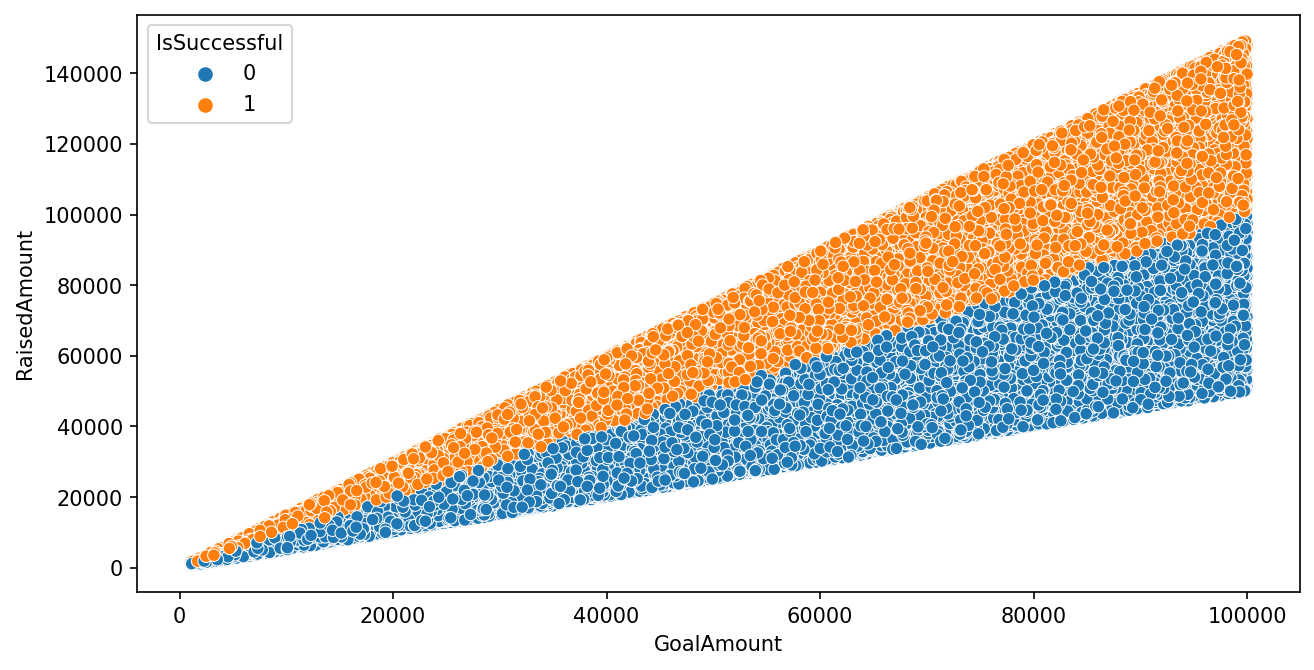

In [9]:
plt.figure(figsize=(10, 5), dpi=150)
sns.scatterplot(data=df, x="GoalAmount", y="RaisedAmount", hue="IsSuccessful");

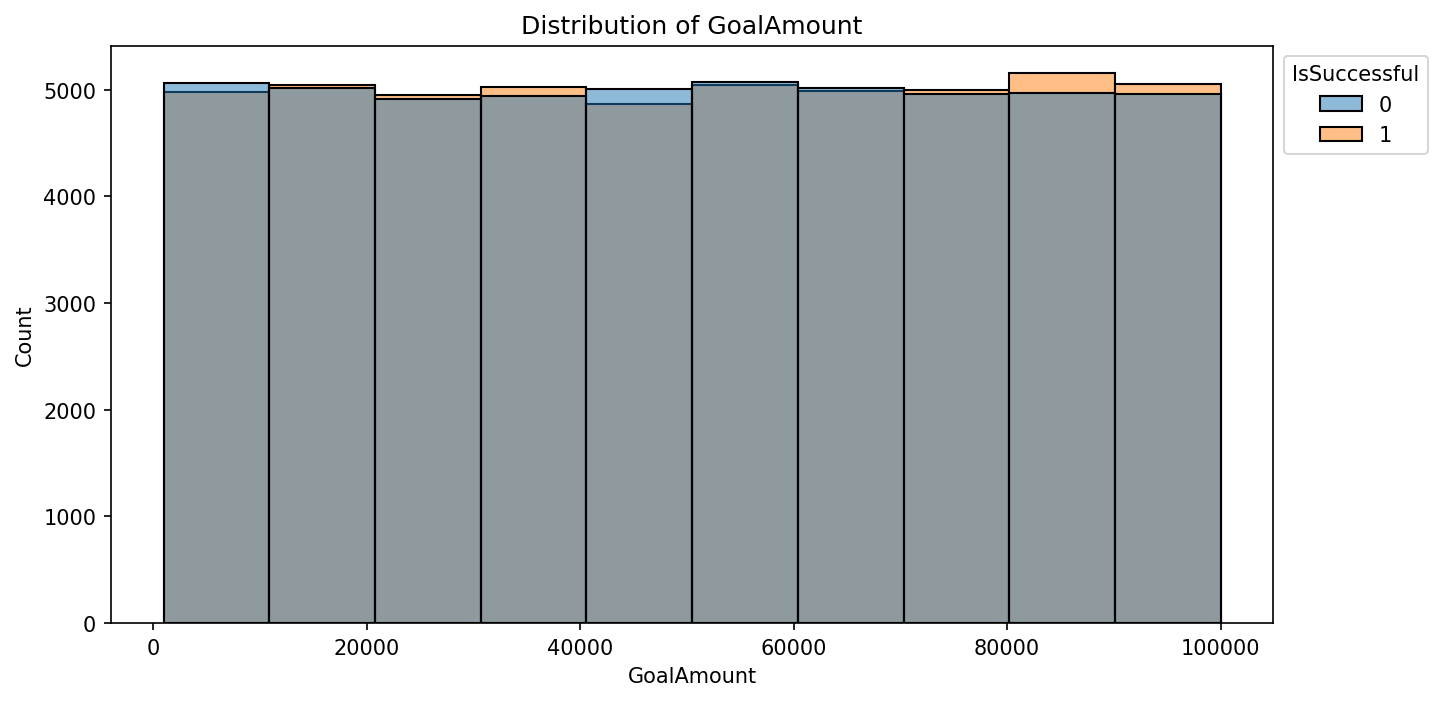

In [10]:
plt.figure(figsize=(10, 5), dpi=150)
plt.title('Distribution of GoalAmount')
plot = sns.histplot(data=df, x="GoalAmount", hue="IsSuccessful", bins=10)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1));

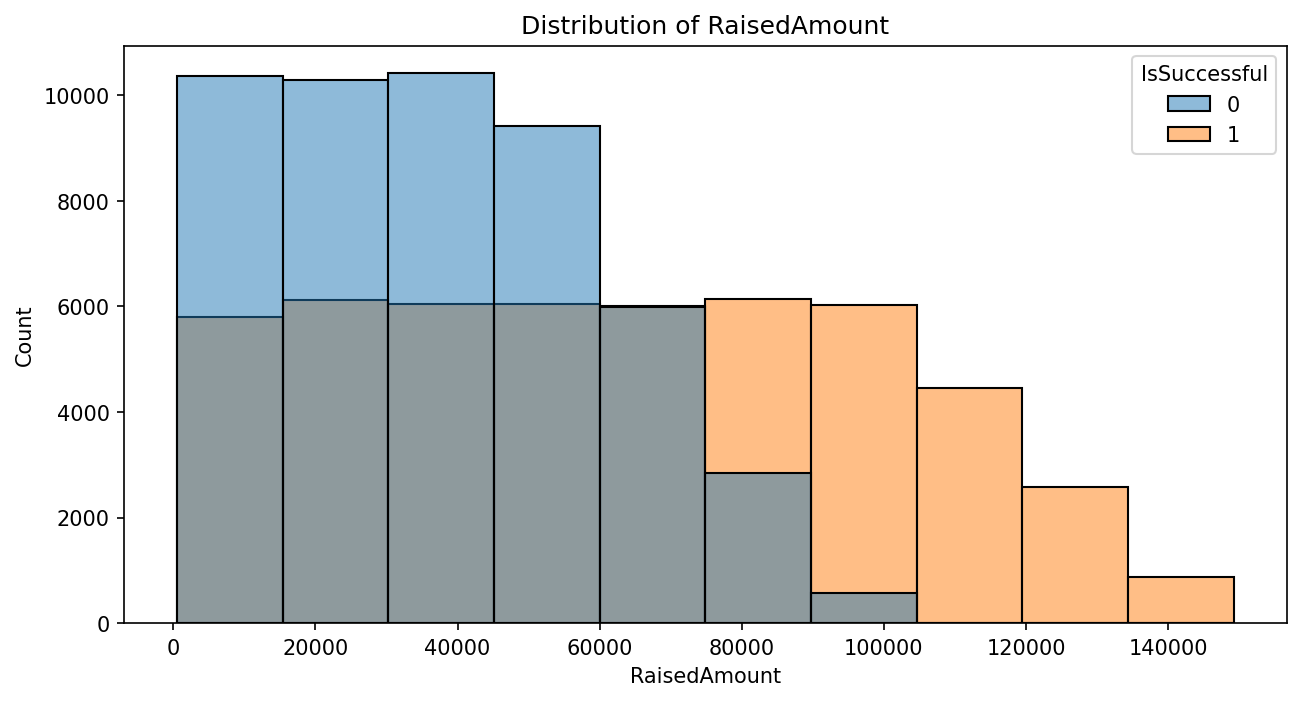

In [11]:
plt.figure(figsize=(10, 5), dpi=150)
plt.title('Distribution of RaisedAmount')
sns.histplot(data=df, x="RaisedAmount", hue="IsSuccessful", bins=10);

In [12]:
def plot_countplot(data=df, title=None, x=None, hue=None):
    plt.figure(figsize=(8, 4), dpi=150)
    plt.title(title if title else None)
    plot = sns.countplot(df, x=x if x else None, hue=hue if hue else None)
    plot.bar_label(plot.containers[0]) if x else None
    plot.bar_label(plot.containers[1]) if hue else None
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1)) if hue else None

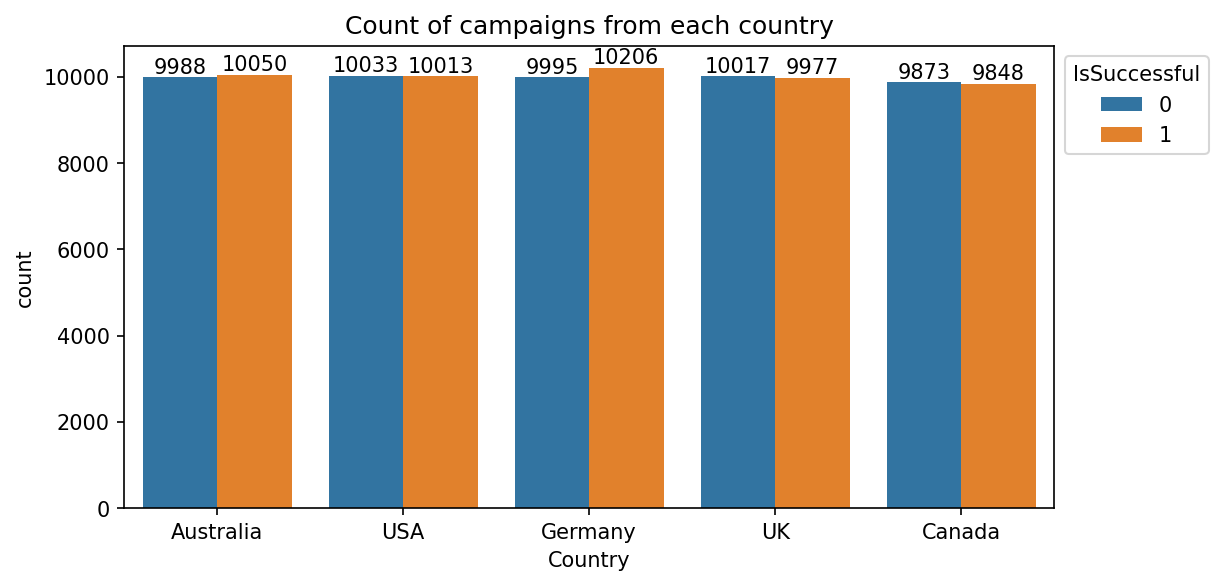

In [13]:
plot_countplot(title='Count of campaigns from each country', x='Country', hue='IsSuccessful')

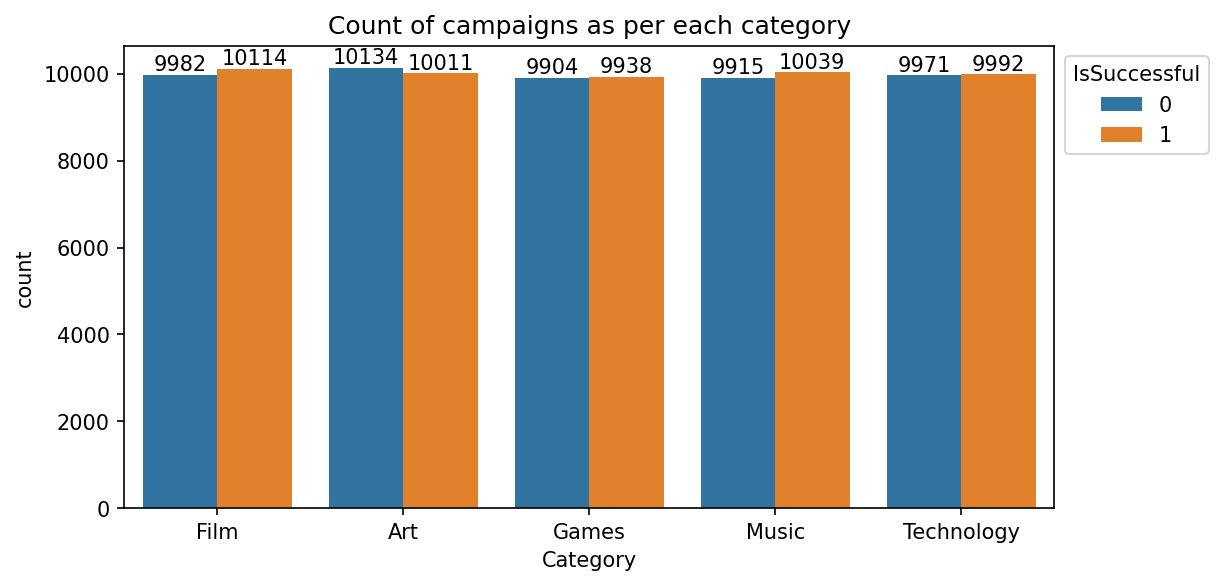

In [14]:
plot_countplot(title='Count of campaigns as per each category', x='Category', hue='IsSuccessful')

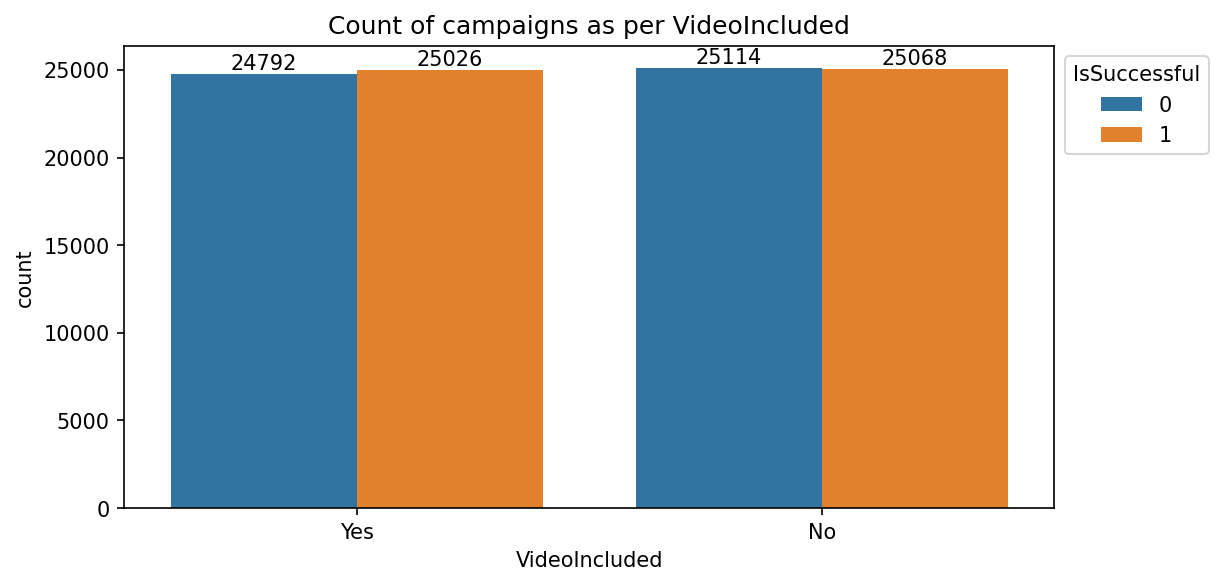

In [15]:
plot_countplot(title='Count of campaigns as per VideoIncluded', x='VideoIncluded', hue='IsSuccessful')

# Train-Validation-Test split

In [16]:
# Separating features and labels
X = df.drop(['IsSuccessful', 'CampaignID'], axis=1)
y = df['IsSuccessful']

In [17]:
# Train-validation-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=101)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=101)

# Data pre-processing

In [18]:
scaler = MinMaxScaler()

def encode_and_transform(dataframe, training_data=True):
    """
    This function takes in a dataframe and applies the following transformations on its columns:
    1. If the dataframe belongs to the training set then the fit_transform() method of the MinMaxScaler will be used on its columns.
    2. If the dataframe belongs to the test set, only the transform() method of the MinMaxScaler will be used.
    3. If a categorical column has two unique values, those values will be mapped to 0 and 1.
    4. If a categorical column has more than k unique values (k>2), k binary features will be created out of that column.
    """
    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype in ('int64', 'float64')]
    cat_cols_3_or_more = [col for col in dataframe.columns if dataframe[col].dtype == object and dataframe[col].nunique() > 2]
    cat_cols_2 = [col for col in dataframe.columns if dataframe[col].dtype == object and dataframe[col].nunique() == 2]
    
    if not training_data:
        dataframe[num_cols] = scaler.transform(dataframe[num_cols])
    else:
        dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])
        
    dataframe = pd.get_dummies(dataframe, columns=cat_cols_3_or_more, dtype=int)
    
    for col in cat_cols_2:
        vals = list(dict(dataframe[col].value_counts()).keys())
        mapping = {vals[0]: 0, vals[1]: 1}
        dataframe[col] = dataframe[col].map(mapping)
    
    return dataframe

In [19]:
X_train_transformed = encode_and_transform(X_train)
X_valid_transformed = encode_and_transform(X_valid, training_data=False)
X_test_transformed = encode_and_transform(X_test, training_data=False)

# Model training

In [20]:
model = XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.05,
    reg_lambda=1,
    scale_pos_weight=1,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
)

model.fit(X_train_transformed, y_train, early_stopping_rounds=5, eval_set=[(X_valid_transformed, y_valid)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# Model predictions

In [21]:
preds = model.predict(X_test_transformed)
from sklearn.metrics import accuracy_score as acc
score = round(acc(y_test, preds), 4)
print(f"The model accuracy on the test dataset is {score*100}%.")

The model accuracy on the test dataset is 99.15%.


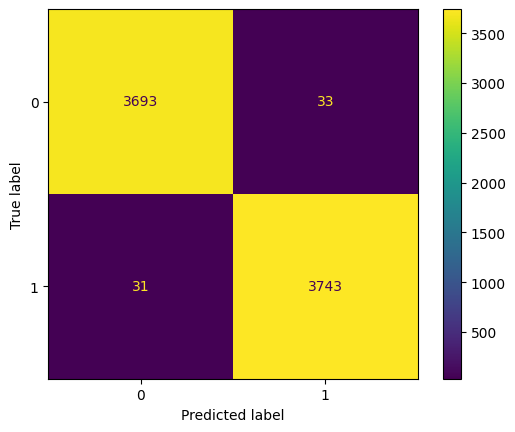

In [22]:
# Confusion matrix
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();